In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi16')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1000.55it/s]

Using control points [2.97349102e-08 4.54975341e-08 7.47629522e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


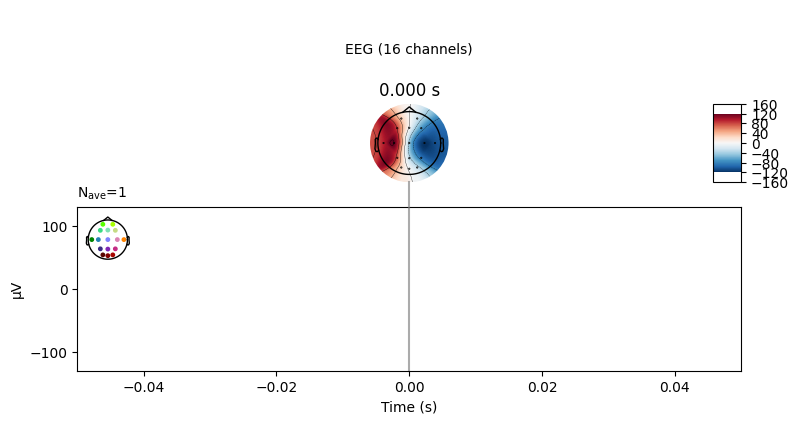

In [7]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=4, extents=(1, 40), duration_of_trial=0.001, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Algo

In [4]:
from invert.util import thresholding
resid = lambda y, phi: y - phi@np.linalg.pinv(phi)@y
yy = y[:, 0]
yy -= yy.mean()

K = int(n_chans/2)
b = leadfield.T @ yy
T0 = np.where(thresholding(b, K) != 0)[0]
R = resid(yy, leadfield[:, T0])
T_list = [T0, ]
R_list = [R, ]

for i in range(1, n_chans+1):
    b = leadfield.T @ R_list[-1]
    new_T = np.where(thresholding(b, K) != 0)[0]
    T_tilde = np.unique(np.concatenate([T_list[i-1], new_T]))
    
    xp = np.linalg.pinv(leadfield[:, T_tilde]) @ yy
    T_l = T_tilde[np.where(thresholding(xp, K) != 0)[0]]
    T_list.append( T_l )
    R = resid(yy, leadfield[:, T_l])
    R_list.append( R )

    if np.linalg.norm(R_list[-1]) > np.linalg.norm(R_list[-2]) or i==n_chans:
        T_l = T_list[-2]
        x_hat = np.zeros(n_dipoles)
        x_hat[T_l] = np.linalg.pinv(leadfield[:, T_l]) @ yy
        print("i = ",i)
        break




i =  1


# Plot

Using control points [0.         0.         0.93906501]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


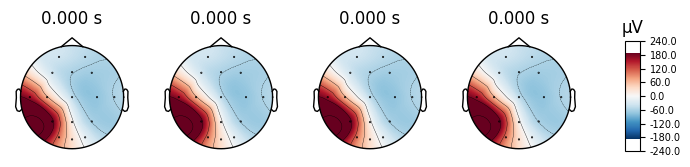

In [5]:
%matplotlib qt
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / abs(x_hat).max()
# stc_.data = x_hat

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Estimation', 'title',
               font_size=14)

eeg = leadfield @ x_hat
evoked = mne.EvokedArray(eeg[:, np.newaxis], info)
evoked.plot_topomap()